# RNN with TensorFlow API for Time-series prediction

In this notebook, we experiment with a time-series data set using recurrent neural network with TensorFlow API.

![Image](./Images/rnn-1.jpg)

First, we create a time series data set with simple sinusoidal function.

Then we create a single-layer recurrent neural network (RNN) cell and train it with a batch of sampled data from the time series. Here, the ___X-feature___ is a slice of time-sampled data and the output ___y___ is the time-shifted data by one unit of time.

Thereaftre, we show the predicted value of time-shifted data by 1 unit of time.
We also try to predict into future by multiple time units and see the result.

In [578]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Time Series Data Class Definition
We define a Time Series Data class with couple of convenient functions

In [579]:
class TimeSeriesData():
    """
    Time series data generation class with convenients functions
    
    num_points: Number of points to be generated
    xmin: Minimum limit
    xmax: Maximum limit
    """
    def __init__(self,num_points,xmin,xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
    
    def next_batch(self,batch_size,steps,return_batch_ts=False,add_noise=False,noise_mean=0.0,noise_sd=0.01):
        """
        Generates batches of data sampled from the time series data.
        Accepts batch_size and steps input from user to determine the length and number of batches.
        Also adds Gaussian noise to the sampled points as per user's choice (noise mean and std.dev can be specified)
        """
        
        # Grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1)
        
        # Convert to be on time series
        ts_start = rand_start * (self.xmax- self.xmin - (steps*self.resolution))
        
        # Create batch Time Series on t axis
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution
        
        # Create Y data for time series in the batches
        y_batch = np.sin(batch_ts)
        
        # Add noise if chosen by the user
        if (add_noise):
            print("Added Gaussian noise with mean={} and std.dev={}\n".format(noise_mean,noise_sd))
            y_batch = y_batch+np.random.normal(loc=noise_mean,scale=noise_sd,size=steps+1).reshape(batch_size,steps+1)
        
        # Format for RNN
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_ts
        
        else:
            
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 
        

### Instantiating time series data and plotting

In [580]:
# Variables for the time series
points = 250
t_min = 0
t_max = 10

In [581]:
ts_data = TimeSeriesData(points,t_min,t_max)

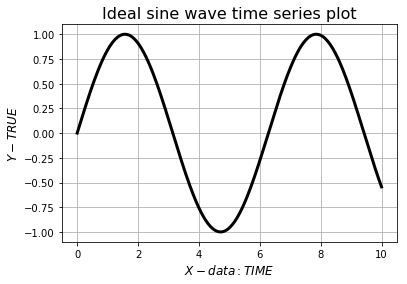

In [582]:
plt.title("Ideal sine wave time series plot",fontsize=16)
plt.xlabel("$X-data: TIME$", fontsize=12)
plt.ylabel("$Y-TRUE$",fontsize=12)
plt.grid(True)
plt.plot(ts_data.x_data,ts_data.y_true,'k',lw=3)

### Creating batch of data and visualizing

In [691]:
# Batch size
batch_size = 1
# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 30

In [692]:
y1,y2,ts = ts_data.next_batch(batch_size,num_time_steps,return_batch_ts=True,
                              add_noise=False,noise_mean=0.0,noise_sd=0.1)

In [693]:
ts

array([[ 0.23204603,  0.27204603,  0.31204603,  0.35204603,  0.39204603,
         0.43204603,  0.47204603,  0.51204603,  0.55204603,  0.59204603,
         0.63204603,  0.67204603,  0.71204603,  0.75204603,  0.79204603,
         0.83204603,  0.87204603,  0.91204603,  0.95204603,  0.99204603,
         1.03204603,  1.07204603,  1.11204603,  1.15204603,  1.19204603,
         1.23204603,  1.27204603,  1.31204603,  1.35204603,  1.39204603,
         1.43204603]])

In [694]:
y1.shape

(1, 30, 1)

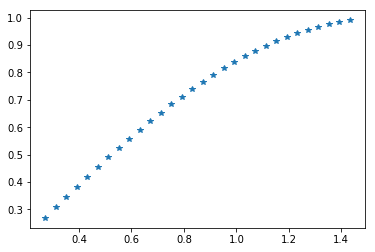

In [695]:
# Because of the shapes involved (see above), we need to flatten the outputs of next_batch method
for i in range(batch_size):
    plt.figure()
    plt.plot(ts[i].flatten()[1:],y2[i].flatten(),'*')

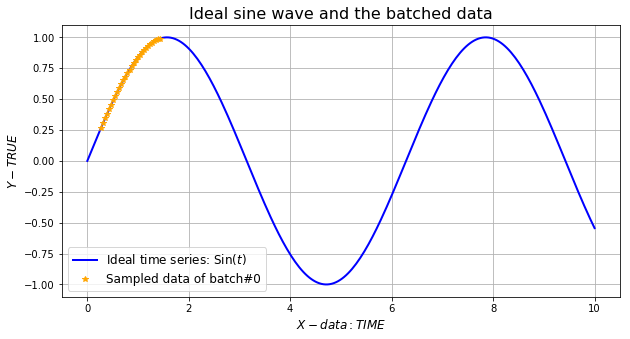

In [696]:
plt.figure(figsize=(10,5))
plt.title("Ideal sine wave and the batched data",fontsize=16)
plt.xlabel("$X-data: TIME$", fontsize=12)
plt.ylabel("$Y-TRUE$",fontsize=12)
plt.grid(True)
plt.plot(ts_data.x_data,ts_data.y_true,'b',lw=2, label='Ideal time series: Sin($t$)')
for i in range(batch_size):
    plt.plot(ts[i].flatten()[1:],y2[i].flatten(),'*',c='orange',label='Sampled data of batch#{}'.format(i))
plt.legend(fontsize=12)

### Illustration of a training instance and what to predict

We are trying to predict a time series shifted over by t+1

In [697]:
train_inst = np.linspace(1.1,1.1 + ts_data.resolution * (num_time_steps + 1), num_time_steps+1)

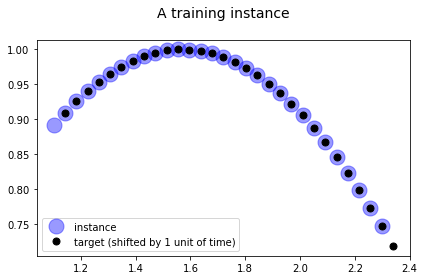

In [698]:
plt.title("A training instance\n", fontsize=14)
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), "bo", markersize=15,alpha=0.4,label="instance")
plt.plot(train_inst[1:], ts_data.ret_true(train_inst[1:]), "ko", markersize=7, 
         label="target (shifted by 1 unit of time)")
plt.legend()
plt.tight_layout()

# Creating the Model

In [699]:
tf.reset_default_graph()

### Constants

In [700]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.0001
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 3000
# Size of the batch of data specified before

### Placeholders

In [701]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


### RNN Cell Layer

Play around with the various cells in this section, compare how they perform against each other.

In [702]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons, activation=tf.nn.relu),
    output_size=num_outputs)

### Dynamic RNN Cell

In [703]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss Function and Optimizer

In [704]:
loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

### Init Global Variables

In [705]:
init = tf.global_variables_initializer()

## Session

In [706]:
# ONLY FOR GPU USERS:
# https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [707]:
saver = tf.train.Saver()

In [708]:
error = []
iterations = []
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations+1):
        
        X_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
        if iteration % 100 == 0:
            
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMean squared error:", mse)
            error.append(mse)
            iterations.append(iteration)
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	Mean squared error: 0.339905
100 	Mean squared error: 0.378161
200 	Mean squared error: 0.00162874
300 	Mean squared error: 0.0850089
400 	Mean squared error: 0.0477067
500 	Mean squared error: 0.0156491
600 	Mean squared error: 0.0132947
700 	Mean squared error: 0.00253416
800 	Mean squared error: 0.000342132
900 	Mean squared error: 0.00549321
1000 	Mean squared error: 0.00177276
1100 	Mean squared error: 0.0190185
1200 	Mean squared error: 0.000654687
1300 	Mean squared error: 0.00032703
1400 	Mean squared error: 0.000689357
1500 	Mean squared error: 0.0121179
1600 	Mean squared error: 0.00089625
1700 	Mean squared error: 0.0117644
1800 	Mean squared error: 0.000566693
1900 	Mean squared error: 0.000703446
2000 	Mean squared error: 0.00018729
2100 	Mean squared error: 0.0018384
2200 	Mean squared error: 0.000957651
2300 	Mean squared error: 0.00531397
2400 	Mean squared error: 0.000346187
2500 	Mean squared error: 0.00547118
2600 	Mean squared error: 0.00071545
2700 	Mean squared

### Plot the MSE error with iterations

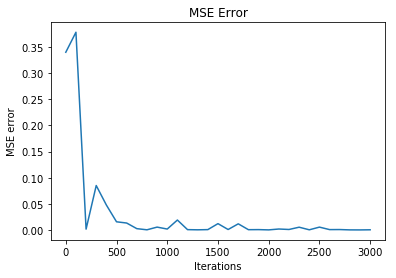

In [709]:
plt.title("MSE Error")
plt.xlabel("Iterations")
plt.ylabel("MSE error")
plt.plot(iterations,error)

### Predicting a time series t+1

In [710]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")   

    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


In [711]:
y_pred

array([[[ 0.82732064],
        [ 0.9030956 ],
        [ 0.91791052],
        [ 0.94477135],
        [ 0.96480948],
        [ 0.97407711],
        [ 0.98555982],
        [ 0.98867005],
        [ 0.9966414 ],
        [ 0.99828398],
        [ 0.99974   ],
        [ 0.99896634],
        [ 0.99558604],
        [ 0.99539173],
        [ 0.99374676],
        [ 0.98442578],
        [ 0.97624928],
        [ 0.96317428],
        [ 0.9524399 ],
        [ 0.93783808],
        [ 0.92265683],
        [ 0.90584135],
        [ 0.88686001],
        [ 0.86734039],
        [ 0.84523487],
        [ 0.82211941],
        [ 0.79676032],
        [ 0.77106172],
        [ 0.74481893],
        [ 0.7169565 ]]], dtype=float32)

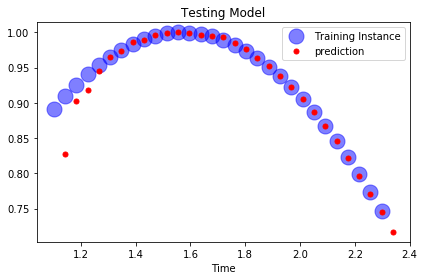

In [712]:
plt.title("Testing Model")

# Training Instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
#plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label="target")

# Models Prediction
plt.plot(train_inst[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")

plt.xlabel("Time")
plt.legend()
plt.tight_layout()

# Generating New Sequences
** Note: Can give wacky results sometimes, like exponential growth**

### Seeding with all zero vector

In [714]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH ZEROS
    zero_seq_seed = [0. for i in range(num_time_steps)]
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        X_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        zero_seq_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


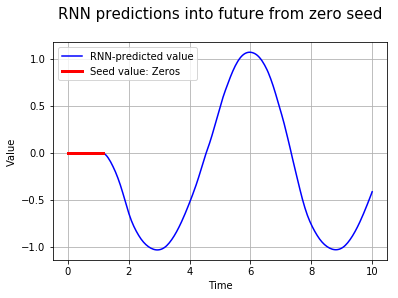

In [721]:
plt.title("RNN predictions into future from zero seed\n", fontsize=15)
plt.plot(ts_data.x_data, zero_seq_seed, "b-", label='RNN-predicted value')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], "r", linewidth=3,label='Seed value: Zeros')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

### Seeding from initial sinusoidal values

In [722]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_time_series_model")

    # SEED WITH Training Instance
    training_instance = list(ts_data.y_true[:num_time_steps])
    for iteration in range(len(ts_data.x_data)-num_time_steps):
        X_batch = np.array(training_instance[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        training_instance.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


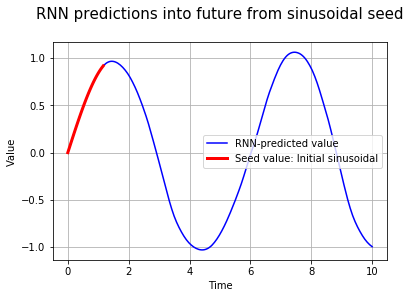

In [723]:
plt.title("RNN predictions into future from sinusoidal seed\n", fontsize=15)
plt.plot(ts_data.x_data, training_instance, "b-",label='RNN-predicted value')
plt.plot(ts_data.x_data[:num_time_steps],training_instance[:num_time_steps], "r-", 
         linewidth=3, label='Seed value: Initial sinusoidal')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)